# Neural Collabrative Filtering

This notebook will perform Neural Collaborative Filtering (NCF) on the MovieLens dataset. When it comes to model the the interaction between user and item features, one often resorts to matrix factorization and apply an inner product on the latent features of users and items. The general framework for Neural network-based Collaborative Filtering is to replace the inner product with a neural architecture that can learn an arbitrary function from data.

In [1]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import MSELoss
import time

np.random.seed(2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Processing

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RatingsDataset(Dataset):
    """Ratings Dataset"""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with ratings.
        """
        self.csv = pd.read_csv('drive/My Drive/Research/ratings.csv')

        self.user_ids = list(self.csv.userId-1)
        self.movie_ids = list(self.csv.movieId-1)
        self.ratings = list(self.csv.rating)

        # Count the numbers of users and movies
        self.userNums = np.max(self.user_ids)+1
        self.movieNums = np.max(self.movie_ids)+1

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        return {
            'user': self.user_ids[idx],
            'movie': self.movie_ids[idx],
            'rating': self.ratings[idx]
        }

    def get_user_number(self):
        return self.userNums

    def get_movie_number(self):
        return self.movieNums

In [5]:
dataset = RatingsDataset()

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# NCF

## Model Implementation - Neural Collaborative Filtering

In [ ]:
class NCF(Module):

    def __init__(self, userNum, itemNum, dim=64, first_layer=128):
        super(NCF, self).__init__()

        # Create embedding layers for user and item data seperately
        self.uEmbd = nn.Embedding(userNum, dim)
        self.iEmbd = nn.Embedding(itemNum, dim)

        self.mf_uEmbd = nn.Embedding(userNum, dim)
        self.mf_iEmbd = nn.Embedding(itemNum, dim)

        self.mlp = nn.Sequential(nn.Linear(dim*2, first_layer),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer, first_layer//2),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//2, first_layer//4),
                                       nn.Dropout(0.25),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(first_layer//4, first_layer//4))

        self.neumf = nn.Linear(dim+first_layer//4, 1)

    def forward(self, userIdx, itemIdx):
        # Embed user and item indices seperately
        uembd = self.uEmbd(userIdx)
        iembd = self.iEmbd(itemIdx)
        embd = torch.cat([uembd, iembd], dim=1)

        # MLP layer captures the non-linearity relationship between users and items
        mlp = self.mlp(embd)
        # MF (Matrix Factorisation) layer captures the linear relationships (dot product) between users and items
        mf = self.uEmbd(userIdx)*self.iEmbd(itemIdx)

        # Concatenate the MF layer output and MLP layer output
        prediction = self.neumf(torch.cat([mlp, mf], dim=1))

        # Predict one entry in the user-iten matrix
        return prediction.flatten()

In [ ]:
# Or use a simplier architecture without the MF layer
class NCF(Module):
    def __init__(self, num_users, num_items, dim=64, first_layer=128):
        super(NCF, self).__init__()

        self.user_embeddings = nn.Embedding(num_users, dim)
        self.item_embeddings = nn.Embedding(num_items, dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim*2, first_layer),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.Linear(first_layer, first_layer//2),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.Linear(first_layer//2, first_layer//4),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.Linear(first_layer//4, 1)
        )

    def forward(self, user_idx, item_idx):
        user_embedded = self.user_embeddings(user_idx)
        item_embedded = self.item_embeddings(item_idx)
        concat_embedded = torch.cat([user_embedded, item_embedded], dim=1)
        return self.mlp(concat_embedded).squeeze()

## Define Training Helper Functions

In [ ]:
# Define function to train for one epoch
def train(loader, model, optim, loss):
    model.train()
    ls = 0.

    # Iterate over batches
    for id, batch in enumerate(loader):
        # Clear the gradients from previous iterations
        optim.zero_grad()
        prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0)) # Here performs the 'forward' step
        loss_ = loss(batch['rating'].float().cuda(0), prediction)
        # Compute gradients using back-propagation
        loss_.backward()
        # Update model parameters
        optim.step()
        ls += loss_.item()

    return ls / len(loader)

# Define function to evaluate on validation/test set
def evaluate(loader, model, loss):
    # Operates in evaluation mode
    model.eval()
    ls = 0.

    # No backward pass
    with torch.no_grad():
        for id, batch in enumerate(loader):
            prediction = model(batch['user'].cuda(0), batch['movie'].cuda(0))
            loss_ = loss(batch['rating'].float().cuda(0), prediction)
            ls += loss_.item()

    return ls / len(loader)

In [ ]:
# Define function to track training and validation losses over epoches
def trainer(trainLoader, valLoader, model, optim, loss, epoch, model_name, verbose=True):

    train_losses = []
    val_losses = []

    best_val = np.inf

    for i in range(epoch):
        start = time.time()
        TL = train(trainLoader, model, optim, loss)
        VL = evaluate(valLoader, model, loss)

        if verbose:
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, TL, VL, (time.time()-start)/60))

        # Update the best model
        if VL < best_val:
            torch.save(model.state_dict(), model_name + '.pth.tar')
            best_val = VL

        train_losses.append(TL)
        val_losses.append(VL)

    # Save the final model
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'min_val_loss': min(val_losses)
    }, model_name + '_loss.pth.tar')

    return torch.load(model_name + '_loss.pth.tar')

## Neural MF Training

In [ ]:
EMBEDDING_DIM = 64

# Hyperparameter tuning
GRID_SEARCH = {
    'batch_size': [128, 256, 512],
    'first_layer': [64, 128, 256],
    'learning_rate': [1e-3, 1e-2]
}

In [ ]:
for bs in GRID_SEARCH['batch_size']:
    for layer in GRID_SEARCH['first_layer']:
        for lr in GRID_SEARCH['learning_rate']:
      # Grid search for best hyperparameters
            trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
            valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

            model = NCF(dataset.get_user_number(), dataset.get_movie_number(),
                        dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

            optim = Adam(model.parameters(), lr=lr)
            loss = nn.L1Loss()
            epoch = 20

            ncf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False) # Don't print each epoch loss

            print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
                                                                                                            layer,
                                                                                                            lr,
                                                                                   ncf_out['min_val_loss']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. Loss: 0.7026097617852383
Batch Size: 128 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. Loss: 0.7345126202473273
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. Loss: 0.7025058361200186
Batch Size: 128 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. Loss: 0.7548875659704208
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.001 - Min. Val. Loss: 0.7084184904129077
Batch Size: 128 | First Layer Neuron: 256 | Learning Rate: 0.01 - Min. Val. Loss: 0.7597322349364941
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.001 - Min. Val. Loss: 0.7015763207887992
Batch Size: 256 | First Layer Neuron: 64 | Learning Rate: 0.01 - Min. Val. Loss: 0.7185569397914104
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. Loss: 0.69516949623059
Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.01 - Min. Val. Loss: 0.72151581

In [ ]:
# Train again with the best hyperparameters and evaluate on the test set
bs = 256
layer = 128
lr = 1e-3
EMBEDDING_DIM = 64

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
# Evaluate the final model on the test data
valLoader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=True)

model = NCF(dataset.get_user_number(), dataset.get_movie_number(),
            dim=EMBEDDING_DIM, first_layer=layer).cuda(0)

optim = Adam(model.parameters(), lr=lr)
loss = nn.L1Loss()
epoch = 40

nf_out = trainer(trainLoader, valLoader, model, optim, loss, epoch, 'ncf_model', False)

print("Batch Size: {} | First Layer Neuron: {} | Learning Rate: {} - Min. Val. Loss: {}".format(bs,
                                                                                                layer,                                                                              lr,
                                                                                                nf_out['min_val_loss']))

Batch Size: 256 | First Layer Neuron: 128 | Learning Rate: 0.001 - Min. Val. Loss: 0.6945000810500903


## Training Results

In [ ]:
nf_out = torch.load('ncf_model_loss.pth.tar')

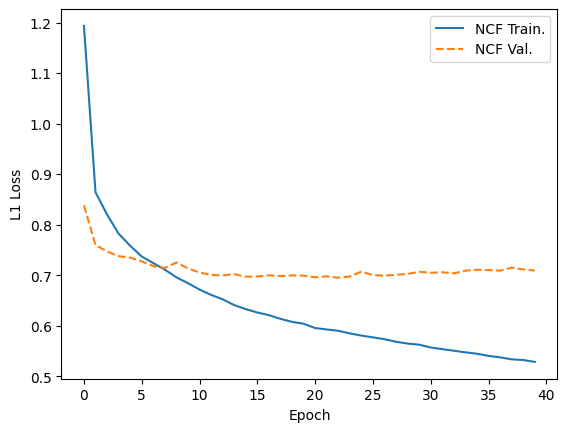

In [ ]:
# plt.title('NCF vs. NGCF')
# plt.plot(ncf_out['train_losses'], label='NGCF Train.')
# plt.plot(ncf_out['val_losses'], label='NGCF Val.', linestyle='--')
plt.plot(nf_out['train_losses'], label='NCF Train.')
plt.plot(nf_out['val_losses'], label='NCF Val.', linestyle='--')
_ = plt.ylabel('L1 Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
# plt.savefig('ncf_ngcf.png', bbox_inches='tight', dpi=200)

## Produce Recommendations for a Test User

In [ ]:
# Choose a test user ID from the MovieLens dataset
test_user_id = 125  # Replace with the actual test user ID

# Get the movies the test user has interacted with
user_interacted_items = set(item['movie'] for item in dataset if item['user'] == test_user_id)

# Generate movie recommendations for the test user
recommendations = []
for item_id in range(dataset.get_movie_number()):
    # Predict ratings for unseem movies by the test user
    if item_id not in user_interacted_items:
        # Convert item_id to a tensor
        item_tensor = torch.tensor([item_id], dtype=torch.long).cuda(0)
        user_tensor = torch.tensor([test_user_id], dtype=torch.long).cuda(0)

        # Predict rating for unseen movies by the test user
        predicted_rating = model(user_tensor, item_tensor).item()
        recommendations.append((item_id, predicted_rating))

# Sort recommendations by predicted rating in descending order
recommendations.sort(key=lambda x: x[1], reverse=True)

# Select the top-N recommended items
top_n_recommendations = recommendations[:3s0]  # Replace N with the desired number of recommendations

# Print the top-N recommended items
for item_id, predicted_rating in top_n_recommendations:
    print(f"Item ID: {item_id}, Predicted Rating: {predicted_rating:.2f}")

Item ID: 35879, Predicted Rating: 5.64
Item ID: 38103, Predicted Rating: 5.56
Item ID: 6958, Predicted Rating: 5.51
Item ID: 1427, Predicted Rating: 5.45
Item ID: 32288, Predicted Rating: 5.42
Item ID: 4590, Predicted Rating: 5.37
Item ID: 90356, Predicted Rating: 5.37
Item ID: 87749, Predicted Rating: 5.35
Item ID: 17684, Predicted Rating: 5.32
Item ID: 107977, Predicted Rating: 5.31
Item ID: 130005, Predicted Rating: 5.31
Item ID: 51470, Predicted Rating: 5.29
Item ID: 90474, Predicted Rating: 5.28
Item ID: 100635, Predicted Rating: 5.27
Item ID: 4075, Predicted Rating: 5.27
Item ID: 155204, Predicted Rating: 5.27
Item ID: 4730, Predicted Rating: 5.26
Item ID: 131723, Predicted Rating: 5.26
Item ID: 5865, Predicted Rating: 5.24
Item ID: 158284, Predicted Rating: 5.24
Item ID: 146577, Predicted Rating: 5.23
Item ID: 65036, Predicted Rating: 5.22
Item ID: 118537, Predicted Rating: 5.22
Item ID: 69994, Predicted Rating: 5.21
Item ID: 106476, Predicted Rating: 5.20
Item ID: 96074, Predic